In [1]:
import matplotlib
import numpy as np

import API_phonopy as api_ph
import API_phonopy_lammps as api_pl
import phonopy
from phonopy import Phonopy

import Kappa_Kubo as Kubo
from hiphive import ForceConstants
import API_thirdorder as FC3
import matplotlib.pyplot as plt

In [2]:
T = 300 # set temperature

NAC = False # non-analytical calculations
Nrepeat=[3,2,3] # supercell matrix used for FC2
mesh = [8,7,5] # q-mesh, should be consistent with ShengBTE setting.

# Specify the directory and the filenames of POSCAR, phonon lifetimes, and harmonic FCs.

POSCAR_FILE = 'POSCAR' # unit cell structure file for vasp
SCATTRATE_FILE = 'BTE.w_3ph' # file from ShengBTE for scattering rate.
FC2_FILE = 'FORCE_CONSTANTS'

In [3]:
# read fc2 and convert format for phono3py calculations.
phonon = phonopy.load(supercell_matrix=Nrepeat,unitcell_filename=POSCAR_FILE, 
                      force_constants_filename= FC2_FILE)
# create a phonopy object and read the POSCAR, FC2 files. 

phonon.run_mesh(mesh,is_gamma_center=True,with_eigenvectors=True,with_group_velocities=True)
# calculate eigen-frequencies and eigenvectors using Gamma centered mesh. 

In [4]:
freqs = phonon.get_mesh_dict()['frequencies']
weights = phonon.get_mesh_dict()['weights']
qpoints = phonon.get_mesh_dict()['qpoints'] # irreducible wedge

scatt_rate_ph = Kubo.read_ShengBTE_scattRate(SCATTRATE_FILE,phonon)

In [5]:
Kappa_Kubo,Kappa_Ph,Kxx_mp,Kyy_mp,Kzz_mp,freqs = Kubo.calc_QHGK_ShengBTE_at_T(phonon,mesh,scatt_rate_ph,T)

largest imaginary frequencies: -2.3288226020574719e-07


/home/xinqian/Softwares/API_Phonons/Kappa_Kubo.py:44: RuntimeWarning: divide by zero encountered in true_divide
  Tau_sr = 1/Scatt_Rate + Tau_sr_offdiag


In [6]:
# Thermal conductivity tensor is arranged as xx, yy, zz, xy, yz, zx.
print('QHGK kappa = ')
print(Kappa_Kubo)
print('Phonon RTA kappa = ')
print(Kappa_Ph)

QHGK kappa = 
[0.40763588 0.42450692 0.39215969 0.0158955  0.01035525 0.05216175]
Phonon RTA kappa = 
[0.21592221 0.24535347 0.19382895 0.01550736 0.00829947 0.04530085]


In [7]:
# Flatten the kappa matrix. 

Nq,Nbrch = Kxx_mp.shape[:2]

Kxx_mp_flat = np.zeros((Nq*Nbrch,Nq*Nbrch))
Freqs_flat = np.zeros(Nq*Nbrch)

for iq in range(Nq):
    Freqs_flat[iq*Nbrch:(iq+1)*Nbrch] = freqs[iq]
    Kxx_mp_flat[iq*Nbrch:(iq+1)*Nbrch,iq*Nbrch:(iq+1)*Nbrch] = Kxx_mp[iq]

Wm,Wn = np.meshgrid(Freqs_flat,Freqs_flat)

Kxx = Kappa_Kubo[0]

Kappa_mat_frac = Kxx_mp_flat/Kxx
gtzero = Kappa_mat_frac>np.mean(Kappa_mat_frac)*0.01

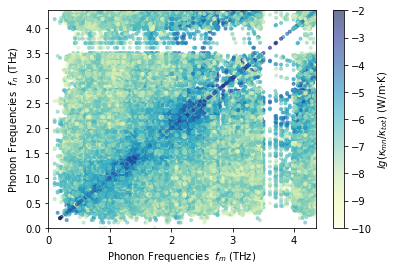

In [8]:
plt.scatter(Wm[gtzero],Wn[gtzero],c=np.log10(Kappa_mat_frac[gtzero]),marker='.',cmap='YlGnBu',alpha=0.6)
plt.colorbar(label='$lg(\kappa_{mn}/\kappa_{tot})$ (W/m$\cdot$K)')
plt.clim([-10,-2])
plt.xlim([0,np.max(Freqs_flat)])
plt.ylim([0,np.max(Freqs_flat)])
plt.xlabel('Phonon Frequencies  $f_m$ (THz)')
plt.ylabel('Phonon Frequencies  $f_n$ (THz)')
plt.savefig("kappa_matrix.png",dpi=300,bbox_inches='tight')